# **Manufacturing Report**
Team 6 Members:

Cole Brauer @ cbrauer@asu.edu

Fuchen Chen @ fchen65@asu.edu

Nathaniel Rossi @ ntrossi@asu.edu

Mason Smith @ mosmith3@asu.edu

#1. Paper Mockup
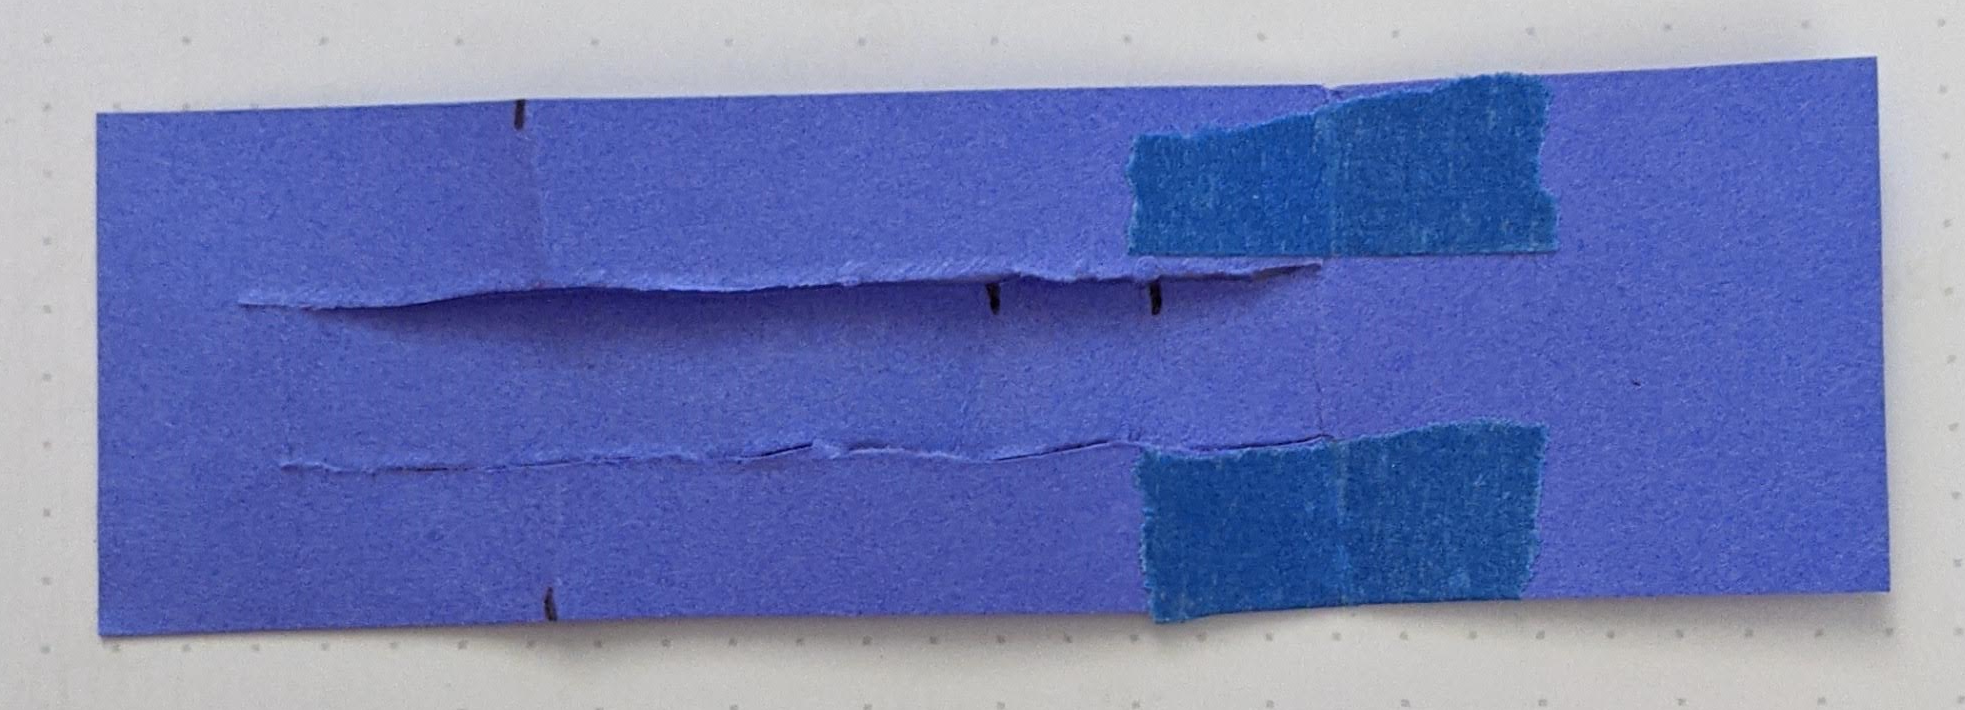

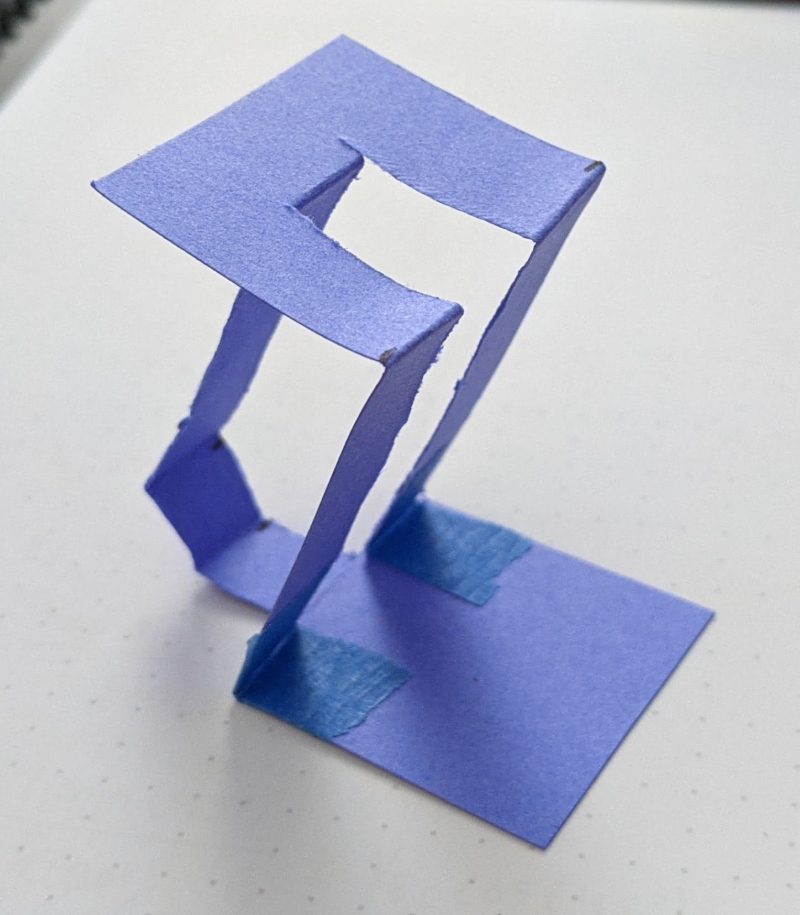

#2. Solidworks Screenshots
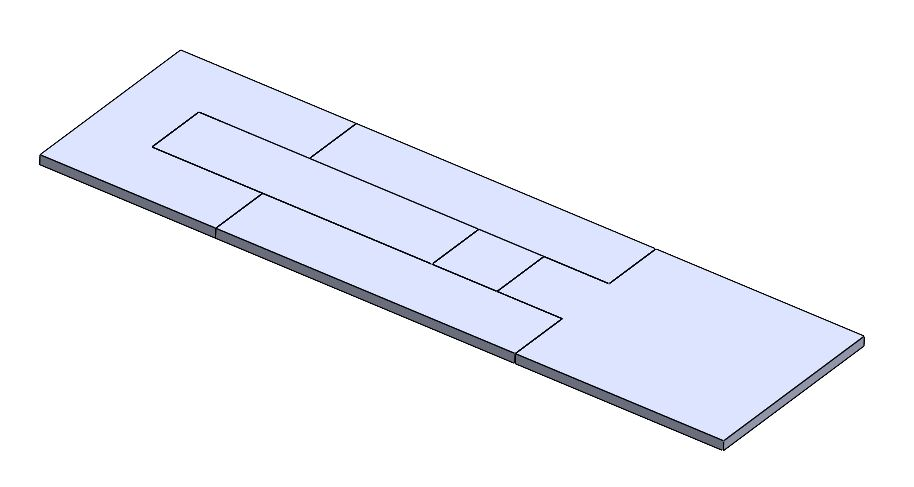

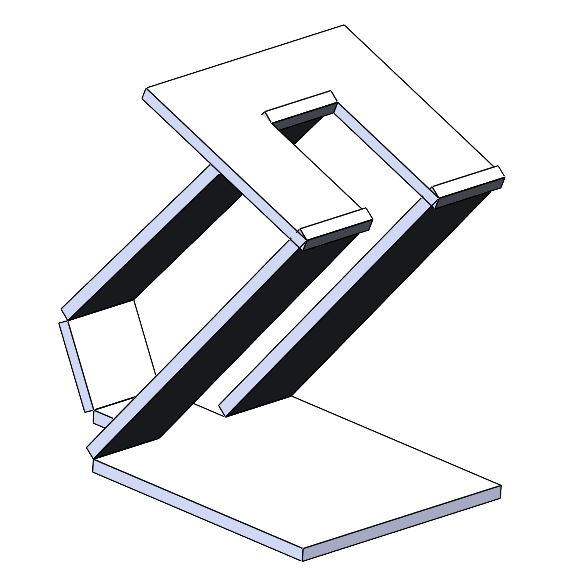

A 3D printed part is also designed to represent the upper leg and payload. Adjustment can easily be done to include more weight and mouting structure. To reduce the total weight, double sided tape or super glue will be used to attach the 3D printed part to the laminate robot. 

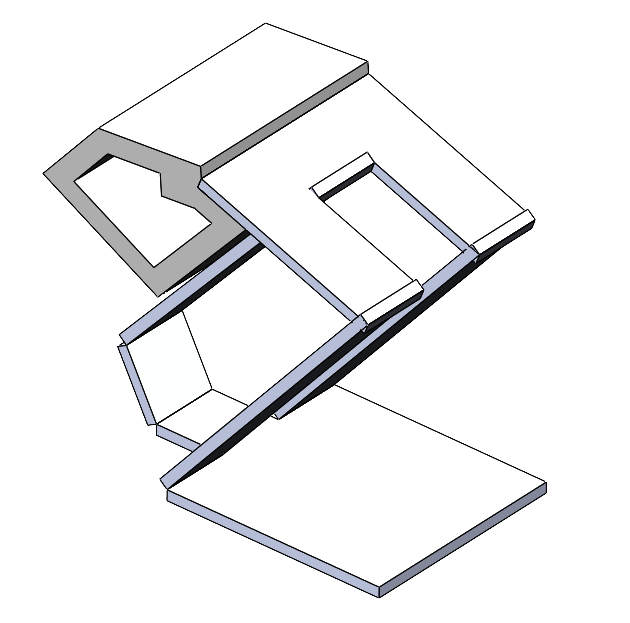

In [ ]:
!pip install idealab_tools foldable_robotics shapely

In [ ]:
%matplotlib inline

import os
import numpy
import shapely.geometry as sg
from math import pi, sin,cos,tan

import idealab_tools.text_to_polygons
import foldable_robotics
from foldable_robotics.layer import Layer
from foldable_robotics.laminate import Laminate
import foldable_robotics.manufacturing
import foldable_robotics.parts.castellated_hinge1
import foldable_robotics.dxf 
import foldable_robotics.manufacturing
import foldable_robotics.solidworks_support
foldable_robotics.display_height=200
foldable_robotics.line_width=.1

### 3. Dxf of Body and Joint Layers
Our desgin cannot be exported correctly using the SolidWorks macro, so the part in its flattened state was exported as a dxf file. Then the file is imported to Adobe Illustrator to mark the joints, cuts, and bodies as shown below. 

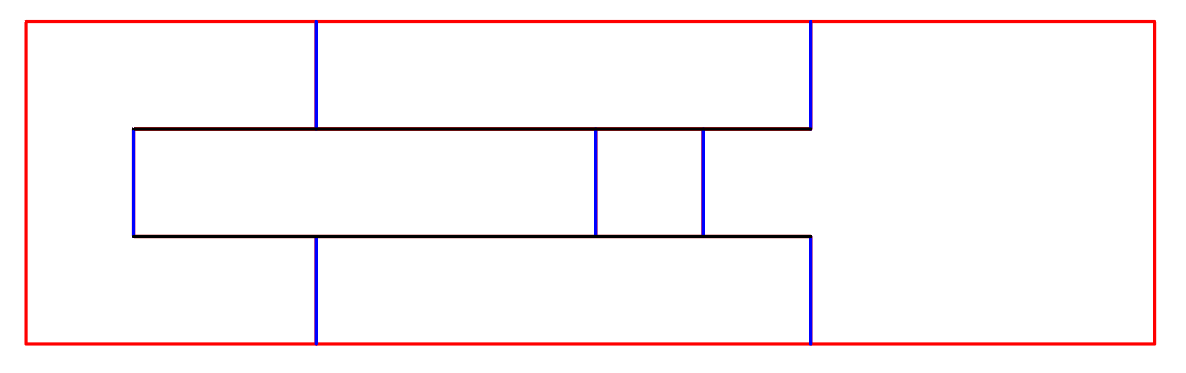

In [ ]:
# The file is in the google drive assignment folder
output_file_name = 'design.dxf'

round_digits = 2
prescale=10
jig_diameter = 5
support_width = 1
kerf = .05
jig_hole_spacing=20
is_adhesive = [False,True,False,True,False]
arc_approx = 10

#4. Jupyter notebook Script



In [ ]:
# Helper functions
def get_bodies(filename, layername, num_layers):
    body = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)

    bodies = [Layer(sg.Polygon(item)) for item in body]
    body = bodies.pop(0)
    for item in bodies:
        body ^= item
    body = body.to_laminate(num_layers)
    return body

def get_hinge_lines(filename,layername):
    hinge_lines1 = foldable_robotics.dxf.read_lines(filename,layer=layername)
    hinge_lines2 = foldable_robotics.dxf.read_lwpolylines(filename,layer=layername)
    hinge_lines3 = []
    for points in hinge_lines2:
        hinge_lines3.append(points[:2])
    hinge_lines = hinge_lines1 +hinge_lines3
    return hinge_lines

def hinge_lines_to_hinges(hinge_lines,hinge):
    lam = Layer().to_laminate(len(hinge))
    all_hinges = []    
    for p3,p4 in hinge_lines:
        all_hinges.append(hinge.map_line_stretch((0,0),(1,0),p3,p4))
    all_hinges = lam.unary_union(*all_hinges)
    return all_hinges

def get_cuts(filename,layername,thickness,num_layers):
    cut_lines = foldable_robotics.dxf.read_lines(filename,layer=layername)
    cut_lines += foldable_robotics.dxf.read_lwpolylines(filename,layer=layername, arc_approx = 10)
    
    cuts = []
    for item in cut_lines:
        cuts.append(Layer(sg.LineString(item)))
    cuts = Layer().unary_union(*cuts)
    cuts<<=thickness/2
    cuts = cuts.to_laminate(num_layers)
    return cuts   

def polys_to_layer(l1):
    l1 = [sg.Polygon(item) for item in l1]
    l11 = Layer(l1.pop(0))
    for item in l1:
        l11 ^= Layer(item)
    return l11

def build_layer_numbers(num_layers, text_size = None, prop=None):
    text_size = text_size or 1
    prop = prop or {'family':'Arial','size':text_size}
    layer_ids = []
    for ii in range(num_layers): 
    
        l = idealab_tools.text_to_polygons.text_to_polygons('L'+str(ii),prop=prop)
        layer_ids.append(l)
    
    layer_ids = [polys_to_layer(item) for item in layer_ids]
    layer_id = Laminate(*layer_ids)
    return layer_id

def calculate_removable_scrap(design,sheet,width,is_adhesive):
    '''this computes all removable scrap given a sheet, a design, and a clearance width'''
    all_scrap = sheet-design

    ru = foldable_robotics.manufacturing.not_removable_up(design,is_adhesive)
    rd = foldable_robotics.manufacturing.not_removable_down(design,is_adhesive)
    
    removable_scrap_up = all_scrap-(ru<<width)
    removable_scrap_down = all_scrap-(rd<<width)

    removable_scrap = removable_scrap_up|removable_scrap_down
    return removable_scrap

def build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive):
    num_layers = len(design2)

    layer_id = build_layer_numbers(num_layers,text_size=jig_diameter)

    design_outer = foldable_robotics.manufacturing.unary_union(design2)
    bb1= (design_outer<<jig_hole_spacing/2).bounding_box()
    (x1,y1),p2 = bb1.bounding_box_coords()
    w,h = bb1.get_dimensions()
    w2 = round(w/jig_hole_spacing)*jig_hole_spacing
    h2 = round(h/jig_hole_spacing)*jig_hole_spacing
    
    points = []
    points.append(sg.Point(x1,y1))
    points.append(sg.Point(x1+w2,y1))
    points.append(sg.Point(x1,y1+h2))
    points.append(sg.Point(x1+w2,y1+h2))
    
    layer_id = layer_id.translate(x1+jig_diameter,y1-jig_diameter/2)
    placement_holes2 = Layer(*points)
    placement_holes2<<=(jig_diameter/2)
    sheet = (placement_holes2<<10).bounding_box()
    placement_holes2=placement_holes2.to_laminate(num_layers)
    sheet=sheet.to_laminate(num_layers)
    
    removable_scrap = calculate_removable_scrap(design2,sheet,support_width,is_adhesive)
    
    web = (removable_scrap-placement_holes2)-layer_id
    return web,sheet

### Single Layer Robot Design
For single layer design, the joint consisits of dashed perforations to weaken the material strength for bending. The density of the perforations can be adjusted for weaker or stronger bending force.


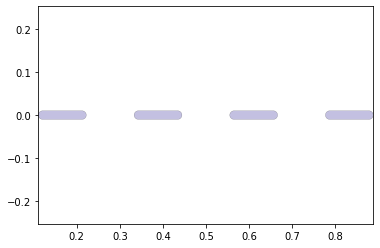

In [ ]:
# Single layer hinge
radius = .01
num_perforations = 4 # Even number to end with a perforation
num_segments = num_perforations*2+1
num_points = num_segments+1
a=numpy.r_[0:1:num_points*1j]
lines = []
for ii in range(int(len(a)/2)-1):
    p1 = sg.Point(a[2*ii+1]+radius,0)
    p2 = sg.Point(a[2*ii+2]-radius,0)
    lines.append(sg.LineString((p1,p2)))
hinge = Layer(*lines)
hinge<<=radius
hinge = Laminate(hinge)
hinge.plot()

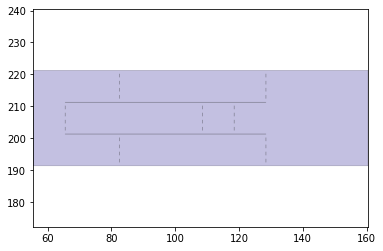

In [ ]:
# Single layer design
NUMLAYERS = len(hinge)

body = get_bodies(output_file_name,'body',NUMLAYERS)
body = foldable_robotics.manufacturing.cleanup(body,.01)
# body.plot()

joint_lines= get_hinge_lines(output_file_name,'joints')
joints = hinge_lines_to_hinges(joint_lines,hinge)
joints = foldable_robotics.manufacturing.cleanup(joints,.001)
# joints.plot()

cuts = get_cuts(output_file_name,'cuts',.02,NUMLAYERS)
# cuts.plot()

design2 = body - joints - cuts
design2.plot()

### Five Layer Robot Design
For five layer design, the joint is a castellated laminate with fleible damping or spring materials in the middle.


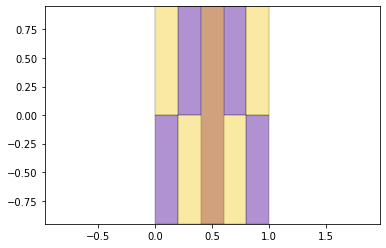

In [ ]:
# Five layer hinge
def hinge_width_calculator(desired_degrees,thickness):
    theta = (180-desired_degrees)*pi/180
    w=thickness/tan(theta)
    return w

hinge = foldable_robotics.parts.castellated_hinge1.generate()
w=hinge_width_calculator(150,1.1)
hinge = hinge.scale(1,w)
hinge.plot()

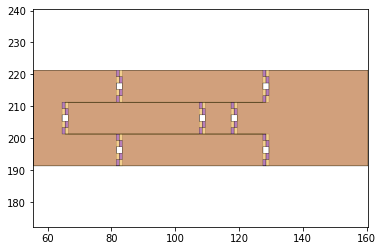

In [ ]:
# Five layer design
NUMLAYERS = len(hinge)

body = get_bodies(output_file_name,'body',NUMLAYERS)
body = foldable_robotics.manufacturing.cleanup(body,.01)
# body.plot()

joint_lines= get_hinge_lines(output_file_name,'joints')
joints = hinge_lines_to_hinges(joint_lines,hinge)
joints = foldable_robotics.manufacturing.cleanup(joints,.001)
# joints.plot()

cuts = get_cuts(output_file_name,'cuts',.02,NUMLAYERS)
# cuts.plot()

design2 = body - joints - cuts
design2.plot()

### Five Layer Manufacturing Design

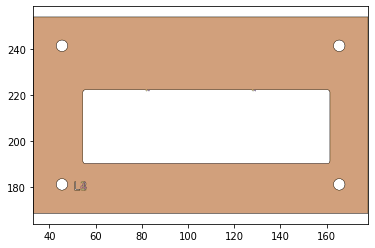

In [ ]:
# Web design
keepout =  foldable_robotics.manufacturing.keepout_laser(design2)
# keepout.plot()

web,sheet=build_web(design2,keepout,support_width,jig_diameter,jig_hole_spacing,is_adhesive)
web.plot()
# sheet.plot()

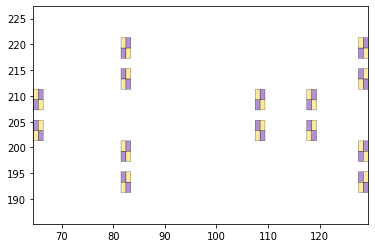

In [ ]:
# Scrap
second_pass_scrap = sheet-keepout
first_pass_scrap = sheet - design2-second_pass_scrap
first_pass_scrap = foldable_robotics.manufacturing.cleanup(first_pass_scrap,.01)
first_pass_scrap.plot()

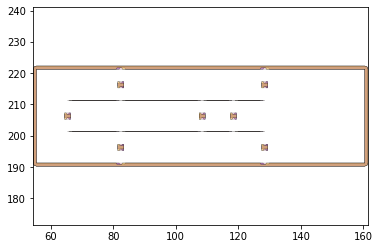

In [ ]:
# Support Design
support = foldable_robotics.manufacturing.support(design2,foldable_robotics.manufacturing.keepout_laser,support_width,support_width/2)
support.plot()

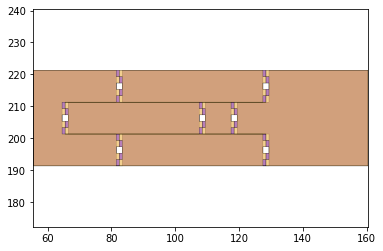

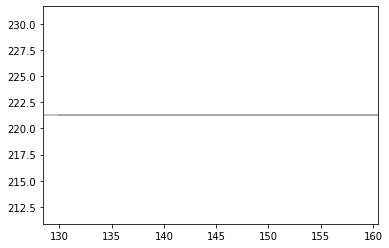

In [ ]:
# All remaining parts after cut
supported_design = web|design2|support
# supported_design.plot()

cut_material = (keepout<<kerf)-keepout
# cut_material.plot()

final_cut = sheet - keepout
final_cut = final_cut[0]
# final_cut.plot()

remaining_material = supported_design-cut_material
# remaining_material.plot()


d3=design2>>1 # a bit bigger design for matching
remaining_parts = foldable_robotics.manufacturing.find_connected(remaining_material,is_adhesive)
for item in remaining_parts:
    if not (item&d3).is_null():
        design2_actual = item
        design2_actual.plot(new=True) # Plot the most similar remaining parts

# Similarity check
check = (design2_actual^design2) 
check.plot(new=True)

## 5. Final .dxf files
There are three first pass cut files for the rigid, flexible, and adhesive layers respectively. There is also a final cut file for releasing the design from the laminate. 

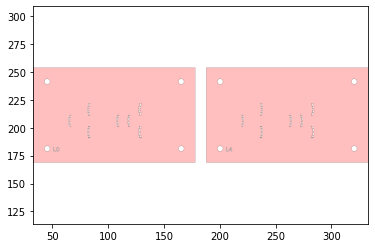

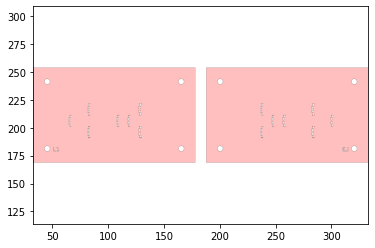

In [ ]:
# Final cut files
w,h = supported_design.get_dimensions()
p0,p1 = supported_design.bounding_box_coords()

rigid_layer = supported_design[0] | (supported_design[-1].translate(w+10,0))
rigid_layer.plot()

l4 = supported_design[3].scale(-1,1)
p2,p3 = l4.bounding_box_coords()
l4 = l4.translate(p0[0]-p2[0]+10+w,p0[1]-p2[1])

adhesive_layer = supported_design[1] | l4
adhesive_layer.plot(new=True)

first_pass = Laminate(rigid_layer,adhesive_layer,supported_design[2])
first_pass.export_dxf('first_pass')
final_cut.export_dxf('final_cut')